In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
!wget https://raw.githubusercontent.com/bikash4044/TuteDude/refs/heads/main/Data%20Science/Assignment6/BakerySales.csv

https://www.kaggle.com/datasets/matthieugimbert/french-bakery-daily-sales

In [8]:
url = "BakerySales.csv"
df = pd.read_csv(url)#, encoding='latin1')
df.head()
df.shape

(234005, 7)

In [9]:
# df.set_index('Month', inplace=True)
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 234005 entries, 0 to 234004
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     234005 non-null  int64  
 1   date           234005 non-null  str    
 2   time           234005 non-null  str    
 3   ticket_number  234005 non-null  float64
 4   article        234005 non-null  str    
 5   Quantity       234005 non-null  float64
 6   unit_price     234005 non-null  str    
dtypes: float64(2), int64(1), str(4)
memory usage: 12.5 MB


In [10]:
df.head()

,Unnamed: 0,date,time,ticket_number,article,Quantity,unit_price
0,0,2021-01-02,08:38,150040.0,BAGUETTE,1.0,"0,90 €"
1,1,2021-01-02,08:38,150040.0,PAIN AU CHOCOLAT,3.0,"1,20 €"
2,4,2021-01-02,09:14,150041.0,PAIN AU CHOCOLAT,2.0,"1,20 €"
3,5,2021-01-02,09:14,150041.0,PAIN,1.0,"1,15 €"
4,8,2021-01-02,09:25,150042.0,TRADITIONAL BAGUETTE,5.0,"1,20 €"


In [19]:
df['rate'] = df['unit_price'].str[:-1].str.replace(',','.')
df['rate'] = df['rate'].astype(float)
df["sales"] = df['Quantity']*df["rate"]



df2 = df.groupby('date')[['sales']].sum()

df2.reset_index(inplace=True)
df2['date'] = pd.to_datetime(df2['date'])

In [20]:
df2.info()

<class 'pandas.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    600 non-null    datetime64[us]
 1   sales   600 non-null    float64       
dtypes: datetime64[us](1), float64(1)
memory usage: 9.5 KB


In [24]:
df2.set_index('date',inplace=True)
df2.head()

,sales
date,
2021-01-02,987.85
2021-01-03,1014.30
2021-01-04,461.90
2021-01-05,515.70
2021-01-07,544.00


As mentioned in the assignment, The data taken by me is monthly data. The "Passenger" column of this table is corresponding to the sales. Hence can be used for prediction.

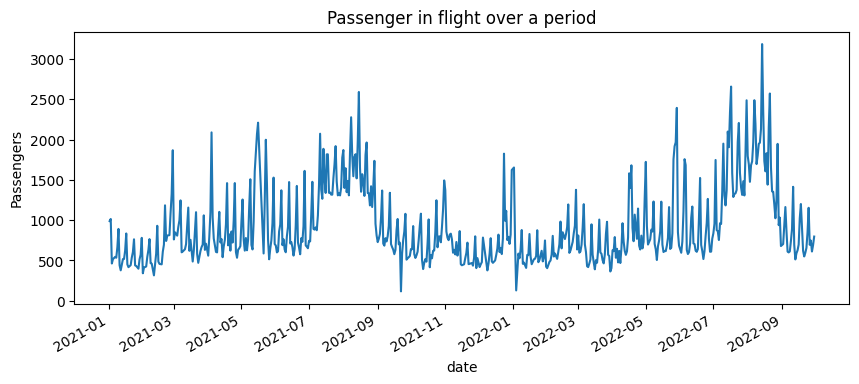

In [37]:

ts = df2['sales']
ts2 = df2['sales']
ts.plot(figsize=(10,4), title = "Passenger in flight over a period")

plt.ylabel("Passengers")
plt.show()

This diagram clearly suggest the presence of seasonality.

In [38]:
ts

date
2021-01-02     987.85
2021-01-03    1014.30
2021-01-04     461.90
2021-01-05     515.70
2021-01-07     544.00
               ...   
2022-09-26     693.75
2022-09-27     746.45
2022-09-28     610.70
2022-09-29     689.20
2022-09-30     795.95
Name: sales, Length: 600, dtype: float64

In [39]:
adf_result = adfuller(ts)
print("ADF Statistic: %.3f, p-value: %.3f" %(adf_result[0], adf_result[1]))

ADF Statistic: -3.129, p-value: 0.024


In [40]:
ts = ts.asfreq('D')

model = sm.tsa.SARIMAX(ts,
                       order=(1,1,1),
                       seasonal_order=(1,1,1,7),
                       enforce_stationarity=False,
                       enforce_invertibility=False
                       )

results = model.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             sales   No. Observations:                  637
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -3936.347
Date:                           Sun, 22 Feb 2026   AIC                           7882.694
Time:                                   17:10:03   BIC                           7904.843
Sample:                               01-02-2021   HQIC                          7891.304
                                    - 09-30-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4776      0.056      8.473      0.000       0.367       0.588
ma.L1         -1.2925      0.068    -18.870

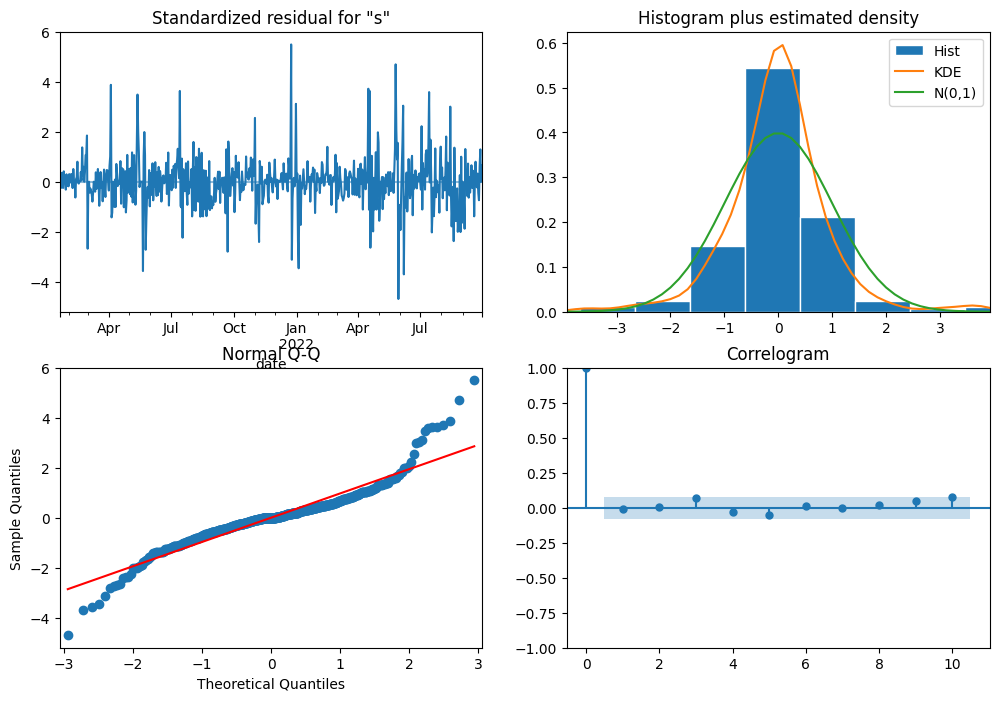

In [41]:
results.plot_diagnostics(figsize=(12,8))
plt.show()

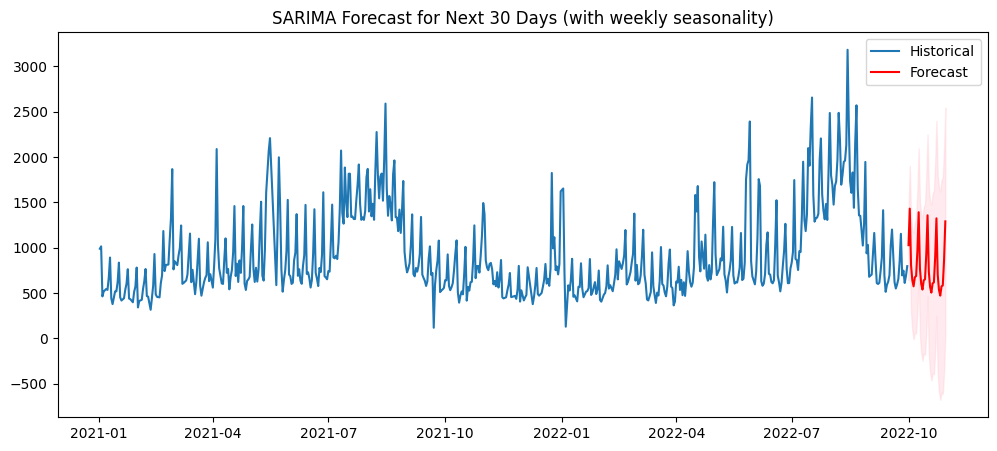

In [42]:
forecast_steps = 30
forecast = results.get_forecast(steps = forecast_steps)
forecast_df = forecast.summary_frame()

plt.figure(figsize = (12,5))
plt.plot(ts2,label="Historical")
plt.plot(forecast_df.index, forecast_df['mean'], label='Forecast', color='red')
plt.fill_between(forecast_df.index,
                 forecast_df['mean_ci_lower'],
                 forecast_df['mean_ci_upper'],
                 color='pink', alpha=0.3)

plt.legend()
plt.title(f"SARIMA Forecast for Next {forecast_steps} Days (with weekly seasonality)")
plt.show()

### Observation
- The blue line shows the historical data and the red line represents the forecast using SARIMA model for next 30 days.
- the forecast shows us the weely trend, as expected.
- The area with red shade is the confidence interval - showing possible fluctuation in the said range.

#### Backtesting on last 15 days

In [49]:
ts2 = ts2.asfreq('D')
train, test  = ts2[:-10], ts2[-10:]


model_bt = sm.tsa.SARIMAX(train,
                       order=(1,1,1),
                       seasonal_order=(1,1,1,7),
                       enforce_stationarity=False,
                       enforce_invertibility=False
                       )

results_bt = model_bt.fit()
pred_bt = results_bt.forecast(steps=10)

#### Error metrics

In [50]:
mae = mean_absolute_error(test, pred_bt)
rmse = np.sqrt(mean_squared_error(test, pred_bt))
mape = np.mean(np.abs((test-pred_bt)/test))*100
print(f"Backtest -> MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}")

Backtest -> MAE: 112.66, RMSE: 142.96, MAPE: 14.80


#### Human readable summary

In [52]:
print("SARIMA Forecast for next 10 days:")
print(f"First day forecast: {forecast_df['mean'].iloc[0]:.0f} Euros "
      f"(range {forecast_df['mean_ci_lower'].iloc[0]:.0f} - {forecast_df['mean_ci_upper'].iloc[0]:.0f})")

SARIMA Forecast for next 10 days:
First day forecast: 1028 Euros (range 639 - 1416)
